In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import models, transforms
from data_generator import show_results
from utils import SquareNet, ImageDataset

## Let's load the data and the model

In [2]:
data = np.load("square_dataset.npz", allow_pickle=True, encoding="latin1")
X = data['X']
Y = data['Y']
dataset = ImageDataset(X,Y)

model = SquareNet()
model.load_state_dict(torch.load('net.pt'))
model.eval()

SquareNet(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (fc): Linear(in_features=524288, out_features=3, bias=True)
)

## Let's evaluate the results

---- Network evaluation ----
-38.9 120.44123 -12.246309
---- Groundtruth ----
-40 114 -12


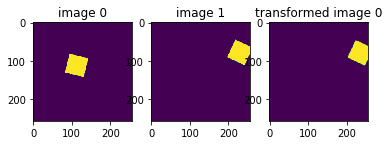

In [3]:
# choose an image in the dataset
i = 25

# let's dig into the dataset
im0 = dataset[i][0]
im1 = dataset[i][1]
x0 = dataset[i][2]['x0']
y0 = dataset[i][2]['y0']
delta_x, delta_y, delta_angle = dataset[i][2]['transformation']

# we need to concatenate the two images as an input
input_net = torch.cat((im0,im1),0).unsqueeze(0)

print("---- Network evaluation ----")
results = model(input_net).detach().numpy()
delta_x_est, delta_y_est, delta_angle_est = results[0][:]
print(delta_x_est, delta_y_est, delta_angle_est)
print("---- Groundtruth ----")
print(delta_x, delta_y, delta_angle)

show_results(im1.numpy()[0,:,:], im0.numpy()[0,:,:], x0, y0, delta_x_est, delta_y_est, delta_angle_est)